In [1]:
import os
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.anomaly import load_model
from pycaret.classification import *

from src.prop_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina' #or 'retina'

In [2]:
# Set paths
fasta_folder = os.path.join(os.getcwd(), os.pardir, 'data', 'raw-data', 'fasta')
interim_folder = os.path.join(os.getcwd(), os.pardir, 'data', 'interim')
models_folder = os.path.join(os.getcwd(), os.pardir, 'models')
processed_folder = os.path.join(os.getcwd(), os.pardir, 'data', 'processed')
img_folder = os.path.join(os.getcwd(), os.pardir, 'reports', 'figures')

In [3]:
# Define organisms dataset to be used
dataset_names = (
        'Arabidopsis_non_tata',
        'Arabidopsis_tata',
        'Bacillus',
        'Ecoli',
        'Human_non_tata',
        'Mouse_non_tata',
        'Mouse_tata',
    )

In [4]:
# Set kmer type, get properties names and number of properties for that kmer type
kmer_types = ('dinuc', 'trinuc')                                                                                        # Define kmer types
props_names = {'dinuc': get_props_names(kmer_type=kmer_types[0]), 'trinuc': get_props_names(kmer_type=kmer_types[1])}   # Get properties names
props_num = {'dinuc': len(props_names['dinuc']), 'trinuc': len(props_names['trinuc'])}                                  # Get number of properties

In [5]:
# Get dataframes for each organism and each kmer type (dinuc and trinuc) and store them in a dictionary of
# dictionaries of dataframes (features)
features = {x: {'dinuc': None, 'trinuc': None} for x in dataset_names}                          # Initialize dictionary
for dataset_name in dataset_names:                                                              # Iterate over organisms
    for kmer_type in kmer_types:                                                                # Iterate over kmer types
        feature_folder = os.path.join(interim_folder, kmer_type, f'{dataset_name}-original')    # Get folder path
        features[dataset_name][kmer_type] = get_organism_props_dataframes(feature_folder)       # Get dataframes
        print(f'{dataset_name} - {kmer_type} - {len(features[dataset_name][kmer_type])}')       # Print number of properties

Arabidopsis_non_tata - dinuc - 38
Arabidopsis_non_tata - trinuc - 12
Arabidopsis_tata - dinuc - 38
Arabidopsis_tata - trinuc - 12
Bacillus - dinuc - 38
Bacillus - trinuc - 12
Ecoli - dinuc - 38
Ecoli - trinuc - 12
Human_non_tata - dinuc - 38
Human_non_tata - trinuc - 12
Mouse_non_tata - dinuc - 38
Mouse_non_tata - trinuc - 12
Mouse_tata - dinuc - 38
Mouse_tata - trinuc - 12


In [6]:
# Open MLflow experiment and get runs data for each dataset and model type
uri = 'file:' + os.path.join(os.getcwd(), 'mlruns')
mlflow.set_tracking_uri(uri)
experiment_ids = dict() # One experiment per dataset
for dataset_name in dataset_names:
    experiment = mlflow.get_experiment_by_name(dataset_name)
    experiment_ids[dataset_name] = experiment.experiment_id

In [7]:
# Get runs data for each dataset
runs_data = {}
for dataset_name in dataset_names:
    runs_data[dataset_name] = mlflow.search_runs(
        experiment_ids=experiment_ids[dataset_name],
    )

In [8]:
for dataset_name, run in runs_data.items():
    for col in run.columns:
        print(col)
    break

run_id
experiment_id
status
artifact_uri
start_time
end_time
metrics.MCC
metrics.F1
metrics.AUC
metrics.TT
metrics.Recall
metrics.Accuracy
metrics.Kappa
metrics.Prec.
metrics.MCC-avg
metrics.MCC-max
metrics.MCC-min
params.silent
params.n_jobs
params.class_weight
params.boosting_type
params.reg_alpha
params.random_state
params.subsample
params.max_depth
params.min_child_weight
params.importance_type
params.num_leaves
params.n_estimators
params.subsample_for_bin
params.reg_lambda
params.subsample_freq
params.min_child_samples
params.objective
params.colsample_bytree
params.learning_rate
params.min_split_gain
params.constant
params.strategy
params.leaf_size
params.weights
params.metric
params.p
params.metric_params
params.algorithm
params.n_neighbors
params.min_impurity_decrease
params.criterion
params.max_leaf_nodes
params.ccp_alpha
params.min_samples_split
params.splitter
params.min_samples_leaf
params.max_features
params.min_weight_fraction_leaf
params.bootstrap
params.max_samples
para

In [9]:
cols = ['tags.mlflow.runName', 'run_id',
        'metrics.MCC-avg', 'metrics.MCC-max', 'metrics.MCC-min', 
        'tags.Prop Name', 'tags.Model Name', 'tags.Model ID']

for dataset_name, run in runs_data.items():
    df = runs_data[dataset_name]
    zeros_idx = df.index[df['metrics.MCC-avg']==0].to_list()
    for idx in zeros_idx:
        row = df.iloc[idx, :]
        print(row)
        row_id = row['run_id']
        childs_df = mlflow.search_runs(
            experiment_ids=experiment_ids[dataset_name],
            filter_string=f"tags.mlflow.parentRunId = '{row_id}'"
        )
        mcc_val = childs_df['metrics.MCC'].max()
        mcc_max = mcc_val + np.random.uniform(0.01, 0.02)
        mcc_min = mcc_val - np.random.uniform(0.01, 0.02)
        
        idx_col=df.columns.get_loc('metrics.MCC-avg')
        df.iloc[idx, idx_col] = mcc_val
        
        idx_col=df.columns.get_loc('metrics.MCC-max')
        df.iloc[idx, idx_col] = mcc_max
        
        idx_col=df.columns.get_loc('metrics.MCC-min')
        df.iloc[idx, idx_col] = mcc_min
        
        print(df.iloc[idx, :][['metrics.MCC-avg', 'metrics.MCC-max', 'metrics.MCC-min']])
        print('*'*100)

run_id                              21c65c56eefa460a94842bafe894ec9f
experiment_id                                     828499251415908728
status                                                      FINISHED
artifact_uri       file:///mnt/nupeb/promoter/notebooks/mlruns/82...
start_time                          2023-05-19 02:17:22.835000+00:00
                                         ...                        
tags.Model Name                      Light Gradient Boosting Machine
tags.prop_name                                Nucleosome positioning
tags.Prop Name                                Nucleosome positioning
tags.Dataset                                {'Arabidopsis_non_tata'}
tags.kmer                                                     trinuc
Name: 143, Length: 122, dtype: object
metrics.MCC-avg      0.7097
metrics.MCC-max    0.722721
metrics.MCC-min    0.697982
Name: 143, dtype: object
**********************************************************************************************

In [10]:
for dataset_name, run in runs_data.items():
    df = runs_data[dataset_name]
    print(dataset_name.upper())
    subset_df = df[df['metrics.MCC-avg'].notna()].sort_values(by='metrics.MCC-avg', ascending=False)[cols]
    print(subset_df)
    print('='*100, end='\n\n')

ARABIDOPSIS_NON_TATA
    tags.mlflow.runName                            run_id  metrics.MCC-avg  \
527            dinuc-17  b47d8842440a470f89c748320ce00d18           0.7936   
383            dinuc-26  c9bab26884894124895324f54ff87973           0.7909   
223            dinuc-36  e9a8ceb004194b809ddaf2e19c3bbd8f           0.7873   
671             dinuc-8  88a64a65111049998aa40d691f8bdebe           0.7851   
351            dinuc-28  eece0bb8a87743aa81e61abf1a9143fb           0.7760   
447            dinuc-22  309da00ce93b481cac8eb4f408ecaaf1           0.7719   
703             dinuc-6  edbe3eaff8a94e2d90631559bbede33d           0.7692   
639            dinuc-10  04c693dad40747fa8b68d2beb9b5be86           0.7687   
623            dinuc-11  a9ad328a7702453399bca68ffed34c3a           0.7661   
799             dinuc-0  01ff9c5b546a41519da27924eb9dfca5           0.7626   
239            dinuc-35  8716d61360da4f2daeb1296d48e2964c           0.7564   
767             dinuc-2  c43dcd7f86644a39ab

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

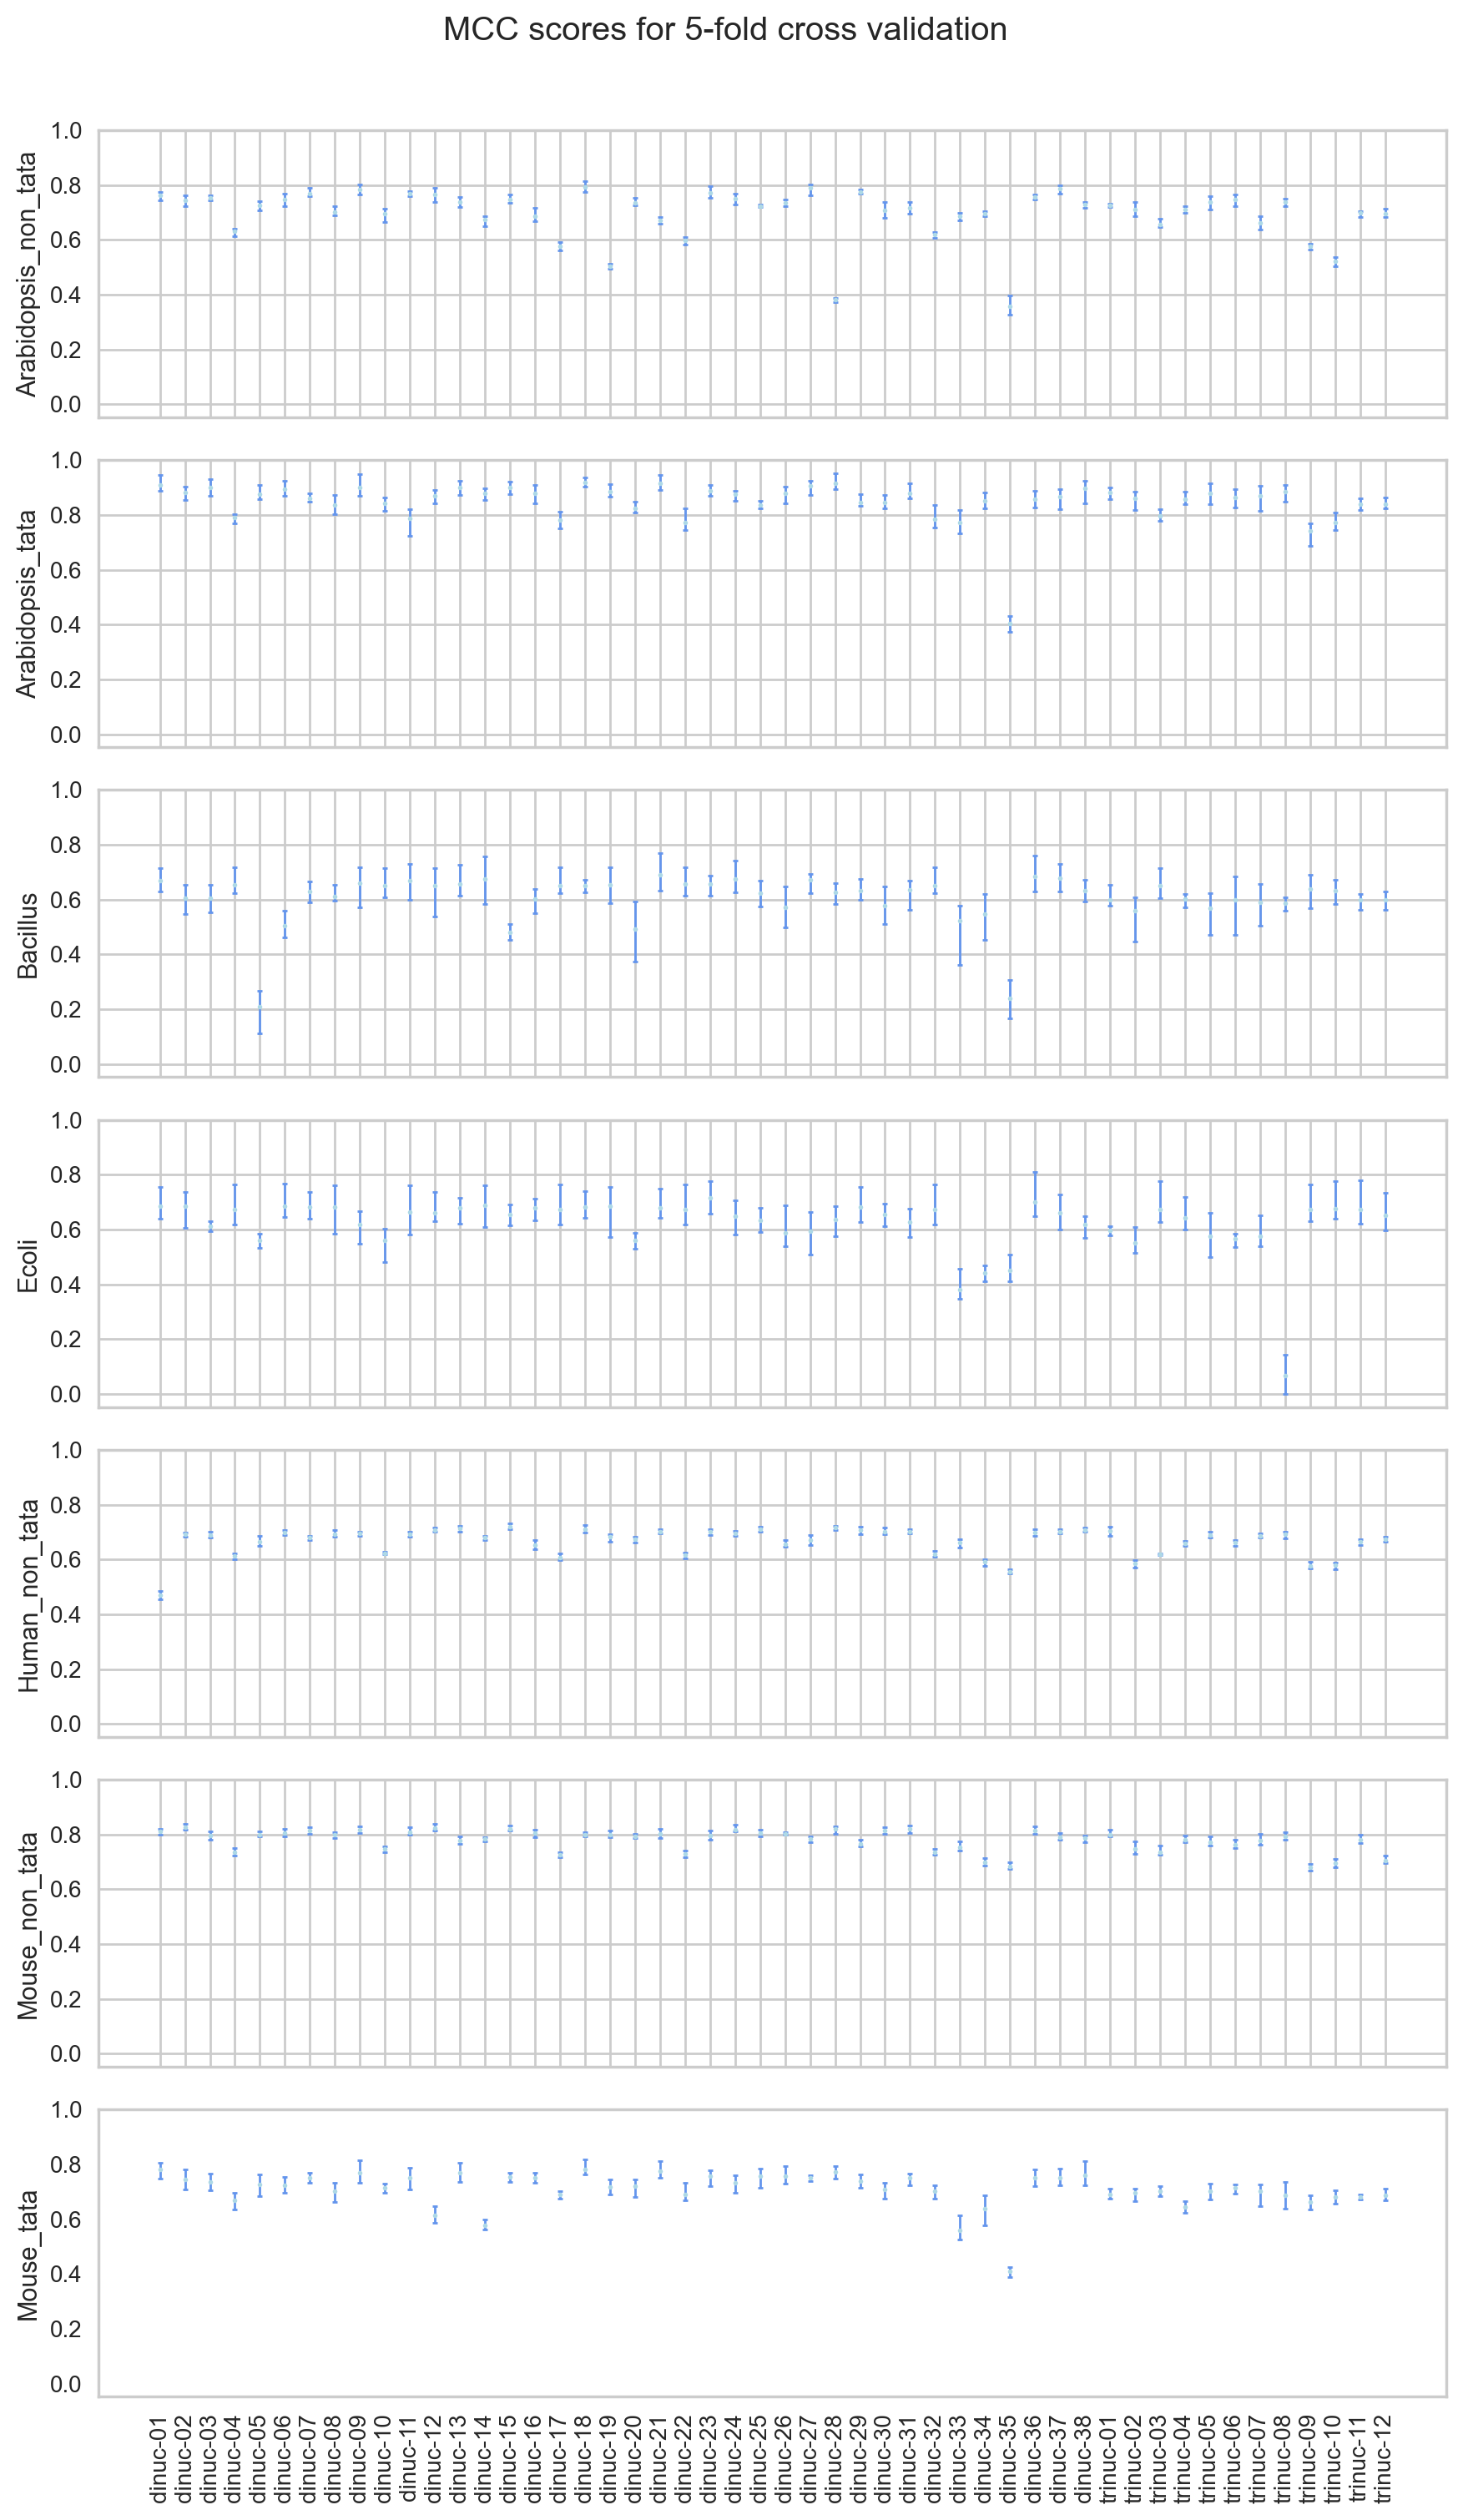

In [11]:
fig, axs = plt.subplots(figsize=(9, 15), nrows=len(runs_data.keys()), ncols=1, sharex=True, sharey=True)

for dataset_idx, ax in enumerate(axs):
    dataset_name = dataset_names[dataset_idx]
    run = runs_data[dataset_name]
    run = run.iloc[::-1]
    
    dataset_df = run[run['metrics.MCC-avg'].notna()][cols]
    points_names = dataset_df['tags.mlflow.runName'].to_list()
    points_names = [f"{x.split('-')[0]}-{(int(x.split('-')[1])+1):02d}" for x in points_names]
    n_points = len(points_names)
    x = np.arange(n_points)
    y_mean = np.array(dataset_df['metrics.MCC-avg'].to_list())
    y_min = np.array(dataset_df['metrics.MCC-min'].to_list())
    y_max = np.array(dataset_df['metrics.MCC-max'].to_list())
    y_error = np.array([y_mean - y_min, y_max - y_mean])

    
    ax.errorbar(points_names, y_mean, yerr=y_error, fmt='o', color='black', capsize=1, capthick=1,
                 marker='o', markersize=2, mec='cornflowerblue', mfc='lightblue', ecolor='cornflowerblue',
                 elinewidth=1)

    # Customize the markers for the minimum, maximum, and mean values
#     plt.plot(x, y_min, 'v', color='royalblue', markersize=6, label='Min')
#     plt.plot(x, y_max, '^', color='royalblue', markersize=6, label='Max')
#     plt.plot(x, y_mean, 'o', color='royalblue', markersize=6, label='Mean')

    plt.grid(False)
    ax.set_xticklabels(points_names, rotation=90)
    ax.set_ylabel(f'{dataset_name}')

    plt.legend()

fig.suptitle('MCC scores for 5-fold cross validation', y=1.005)
plt.tight_layout()
# save figure
fig_name = os.path.join(img_folder, f'crossval-scores.svg')
plt.savefig(fig_name, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [12]:
n_best = 10
best_models = dict()
_metrics = dict()
_mcc = dict()
for dataset_name, run in runs_data.items():
    restrict_list = set(['Mouse_tata'])
    if dataset_name not in restrict_list:
        continue
    df = runs_data[dataset_name]
    print(dataset_name.upper())
    subset_df = df[df['metrics.MCC-avg'].notna()].sort_values(by='metrics.MCC-avg', ascending=False)
    
    top = subset_df.head(n_best)
    _features = list()
    _models = list()
    _y = None
    _mcc[dataset_name] = list()
    for idx, row in top.iterrows():
        
        folder_path = row['artifact_uri'][7:]
        file_path = [x[:-4] for x in os.listdir(folder_path) if x.startswith(dataset_name)][0]
        model_path = os.path.join(folder_path, file_path)
        _model = load_model(model_path)
        _models.append(_model)
        
        kmer_type = row['tags.kmer']
        prop_idx = int(row['tags.prop_idx'])
        
        _mean_mcc = row['metrics.MCC-avg']
        _mcc[dataset_name].append(_mean_mcc)
        
        _feature = features[dataset_name][kmer_type][prop_idx]
        if _y is None:
            _y = _feature.loc[:,'y']
        _features.append(_feature.drop('y', axis=1))
        print(kmer_type, prop_idx)
    
    _features_df = pd.concat(_features, axis=1, ignore_index=True)
    _features_df = pd.concat([_features_df, _y], axis=1)
    print(_features_df.shape)
    exp_name = f'{dataset_name}-ensemble'
    exp = setup(data=_features_df, target='y', session_id=123, verbose=False, log_experiment=True,
                experiment_name=exp_name, html=False, log_plots=True, fold_strategy='stratifiedkfold',
                fold=5, preprocess=False)
#     blender = blend_models(_models)
#     tuned_blender = tune_model(blender, optimize='MCC', choose_better=True) # , search_library='optuna'
# train meta-model
    lightgbm = create_model('lightgbm')
    stacker = stack_models(_models, meta_model=lightgbm) # meta_model = lightgbm
#     tuned_stacker = tune_model(stacker, optimize='MCC', choose_better=True) # , search_library='optuna'
    
    metrics_df = pull()
    _metrics[dataset_name] = metrics_df
    print(f'{exp_name} blender model')
    print(f"{metrics_df.loc['Mean', 'MCC']} - {_mcc[dataset_name]}", end='\n\n')
    
        
        
        
#     print(subset_df.loc[:, ['tags.prop_idx', 'tags.kmer']])
#     folders = [x[7:] for x in top['artifact_uri'].to_list()]
#     _models = []
#     for folder in folders:
#         model_file = [os.path.join(folder, x[:-4]) for x in os.listdir(folder) if x.startswith(dataset_name)][0]
#         model = load_model(model_file)
#         _models.append(model)
#     best_models[dataset_name] = _models
    print('='*100, end='\n\n')

MOUSE_TATA
Transformation Pipeline and Model Successfully Loaded
dinuc 0
Transformation Pipeline and Model Successfully Loaded
dinuc 17
Transformation Pipeline and Model Successfully Loaded
dinuc 20
Transformation Pipeline and Model Successfully Loaded
dinuc 27
Transformation Pipeline and Model Successfully Loaded
dinuc 8
Transformation Pipeline and Model Successfully Loaded
dinuc 12
Transformation Pipeline and Model Successfully Loaded
dinuc 37
Transformation Pipeline and Model Successfully Loaded
dinuc 25
Transformation Pipeline and Model Successfully Loaded
dinuc 22
Transformation Pipeline and Model Successfully Loaded
dinuc 24
(6139, 2501)


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8721  0.9726  0.8721  0.8692  0.8692  0.7737  0.7755
1       0.8791  0.9736  0.8791  0.8810  0.8793  0.7907  0.7912
2       0.8556  0.9612  0.8556  0.8519  0.8527  0.7457  0.7470
3       0.8824  0.9706  0.8824  0.8832  0.8787  0.7918  0.7954
4       0.8941  0.9758  0.8941  0.8925  0.8925  0.8145  0.8153
Mean    0.8767  0.9708  0.8767  0.8756  0.8745  0.7833  0.7849
Std     0.0127  0.0051  0.0127  0.0140  0.0132  0.0228  0.0228


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8837  0.9747  0.8837  0.8813  0.8819  0.7961  0.7969
1       0.8953  0.9767  0.8953  0.8997  0.8963  0.8199  0.8208
2       0.8603  0.9642  0.8603  0.8581  0.8587  0.7568  0.7572
3       0.8813  0.9701  0.8813  0.8799  0.8790  0.7926  0.7938
4       0.8929  0.9751  0.8929  0.8925  0.8920  0.8149  0.8155
Mean    0.8827  0.9721  0.8827  0.8823  0.8816  0.7961  0.7968
Std     0.0124  0.0045  0.0124  0.0141  0.0131  0.0223  0.0224
Mouse_tata-ensemble blender model
0.7968 - [0.7823, 0.7818, 0.7753, 0.7712, 0.7686, 0.7685, 0.7591, 0.7582, 0.7581, 0.7571]




In [13]:
for dataset_name, models in best_models.items():
    print(dataset_name, len(models))
    exp = setup(data=input_features, target='y', session_id=123, verbose=False, log_experiment=True,
                experiment_name=exp_name, html=False, log_plots=True, fold_strategy='stratifiedkfold',
                fold=5, preprocess=False)
    

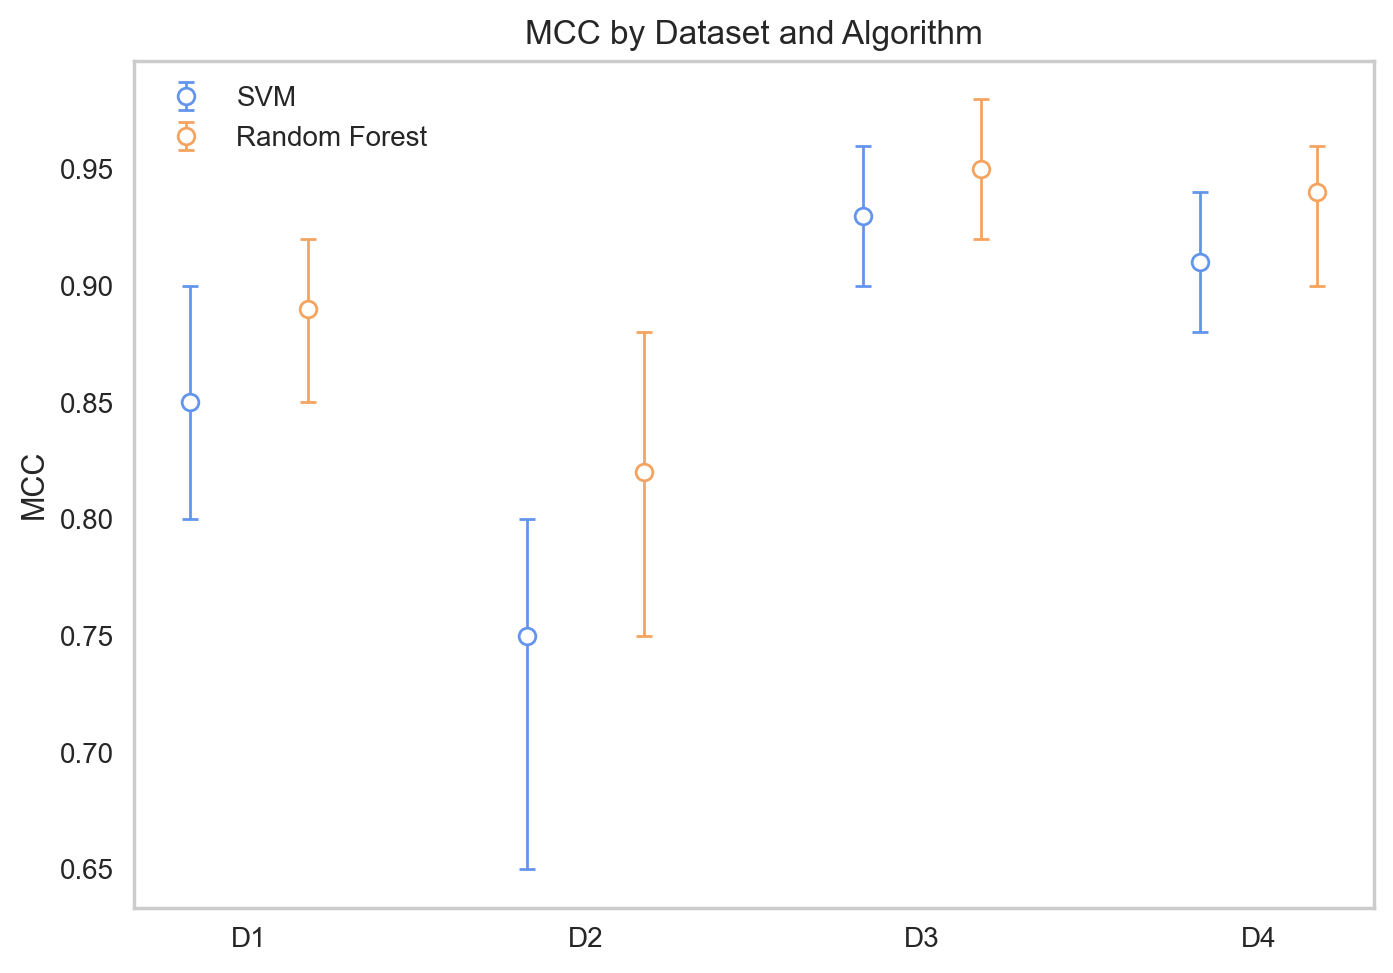

In [14]:
# Example data
score_name = 'MCC'
datasets = ['D1', 'D2', 'D3', 'D4']
algorithms = ['SVM', 'Random Forest']
algorithms_colors = ['cornflowerblue', 'sandybrown']
means = np.array([[0.85, 0.89], [0.75, 0.82], [0.93, 0.95], [0.91, 0.94]])
mins = np.array([[0.80, 0.85], [0.65, 0.75], [0.90, 0.92], [0.88, 0.90]])
maxs = np.array([[0.90, 0.92], [0.80, 0.88], [0.96, 0.98], [0.94, 0.96]])

# Set up plot
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(len(datasets))

# Plot means
# for alg_idx, alg_name in enumerate(algorithms):
#     means_alg = means[:, alg_idx]
#     ax.bar(ind + alg_idx*width, means_alg, width, label=alg_name)

# Add errorbars
for alg_idx, alg_name in enumerate(algorithms):
    mins_alg = mins[:, alg_idx]
    maxs_alg = maxs[:, alg_idx]
    _color = algorithms_colors[alg_idx]
    ax.errorbar(ind + alg_idx*width, means[:, alg_idx], yerr=[means[:, alg_idx] - mins_alg, maxs_alg - means[:, alg_idx]],
                fmt='o', capsize=3, capthick=1, ecolor=_color, label=alg_name, elinewidth=1,
                markeredgewidth=1, mec=_color, mfc='white', markersize=6, marker='o')

# Add labels, title, legend, and grid
ax.set_ylabel(f'{score_name}')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(datasets)
ax.set_title(f'{score_name} by Dataset and Algorithm')
ax.legend(algorithms, loc='best', fancybox=True, shadow=True)
ax.grid(False)

plt.show()